In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

In [78]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
sample = pd.read_csv("data/simple_submission.csv")

C:\Users\Ut Luom\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Ut Luom\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
df_train.head()

,id,label,Field_1,Field_2,Field_3,Field_4,Field_5,Field_6,Field_7,Field_8,...,partner5_H,partner5_K,partner5_L,brief,num_of_phone,Field_78,Field_79,Field_80,Field_81,Field_82
0,0,1,2019-07-24T03:39:02.854Z,2019-07-31T20:10:02Z,1.0,GH,2018-12-27,2018-12-27,2019-01-01,2019-07-31,...,0.0,0.0,0.0,cb1,1.0,NaN,NaN,NaN,NaN,1
1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,4,1.0,NaN,NaN,NaN,NaN,1
2,2,0,2019-01-17T07:15:26.367Z,2019-01-17T07:17:45Z,2.0,T1,2019-01-17,2019-01-17,2019-01-01,2019-12-31,...,0.0,0.0,0.0,1,1.0,33.0,10.769445,6.466667,0.0,2
3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1.0,33.0,10.769445,6.466667,0.0,3
4,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1.0,33.0,10.769445,6.466667,0.0,3


In [80]:
df_test.head()

,id,Field_1,Field_2,Field_3,Field_4,Field_5,Field_6,Field_7,Field_8,Field_9,...,partner5_H,partner5_K,partner5_L,brief,num_of_phone,Field_78,Field_79,Field_80,Field_81,Field_82
0,53030,2019-10-14T01:37:41.959Z,2019-10-14T01:37:41.959Z,2.0,T1,8/27/2019,8/27/2019,9/24/2019,9/23/2020,8/27/2019,...,0.0,0.0,0.0,NaN,2.0,NaN,NaN,NaN,NaN,1
1,53031,2019-09-10T09:20:40.066Z,2019-09-11T07:53:44Z,2.0,T1,9/10/2019,9/10/2019,9/14/2019,9/13/2020,9/10/2019,...,0.0,0.0,0.0,notfound,1.0,NaN,NaN,NaN,NaN,1
2,53032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,1.0,NaN,NaN,NaN,NaN,1
3,53033,2019-10-21T03:29:30.074Z,2019-10-21T04:17:26Z,2.0,T1,10/21/2019,10/21/2019,11/15/2019,11/14/2020,10/21/2019,...,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1
4,53034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,3,1.0,27.0,NaN,27.0,27.0,1


In [81]:
index = df_test['id']

In [82]:
print(df_train.shape)
print(df_test.shape)

(53030, 195)
(20381, 194)


In [83]:
c_train = df_train.copy()
c_test  = df_test.copy()

In [84]:
c_train['train'] = 1
c_test['train'] = 0
df = pd.concat([c_train, c_test], axis=0, sort=False)

### 1. Kiểm tra độ Missing values

In [85]:
#Percentage of NAN Values 
NAN = [(c, df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])

Những feature có độ missing lớn hơn 50% giá trị bị thiếu

In [86]:
NAN = NAN[NAN.percentage > 50]
NAN.sort_values("percentage", ascending=False)

,column_name,percentage
36,Field_35,87.455558
13,Field_12,86.484314
12,Field_11,86.414842
19,Field_18,84.462819
74,maCv,83.133318
...,...,...
2,Field_1,52.835406
111,E_endDate,52.147498
110,E_startDate,52.147498
109,E_numQuery,52.147498


Tạm thời cứ để nguyên vậy đợi sau khi group and select thì ta sẽ drop sau

### 2.Processing Columns

#### 2.1 Nhóm I:

In [87]:
#xử lí date và dateTime
Date = ['Field_{}'.format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 33, 34, 35, 40]]
DateTime = ['Field_{}'.format(i) for i in [1, 2, 43, 44]]
df[Date + DateTime + ['Field_34']].sample(10)

,Field_5,Field_6,Field_7,Field_8,Field_9,Field_11,Field_15,Field_25,Field_33,Field_34,Field_35,Field_40,Field_1,Field_2,Field_43,Field_44,Field_34
13713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35847,2018-12-19,2018-12-19,2019-01-01,2019-12-31,2018-12-19,NaN,NaN,2018-12-19,2021-11-01,2.01612e+07,NaN,2019-01-01,2018-12-19T09:34:09.647Z,2018-12-20T03:25:27Z,2017-01-24T13:11:59.16Z,2019-09-20T04:29:15Z,2.01612e+07
24461,2019-10-31,2019-10-31,2019-10-01,2019-12-31,2019-10-31,NaN,2019-10-31,2019-10-31,2024-03-01,20191013,NaN,2019-10-01,2019-10-31T07:13:26.388Z,2019-10-31T08:46:00Z,2017-01-18T10:48:59.34Z,2019-09-21T02:15:15Z,20191013
15403,2018-12-27,2018-12-27,2019-01-01,2019-12-31,2018-12-27,NaN,NaN,2018-12-27,2017-06-01,20180404,NaN,2019-01-01,2018-12-27T12:54:14.808Z,2019-01-24T07:52:56Z,2017-01-06T15:10:31.83Z,2019-09-26T11:50:05Z,20180404
14729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9629,2018-12-24,2018-12-24,2019-01-01,2019-12-31,2018-12-24,NaN,NaN,2018-12-24,2020-01-01,20180102,NaN,2019-01-01,2018-12-24T09:29:53.315Z,2019-11-08T10:26:41Z,2016-12-01T12:11:16.027Z,2019-10-02T13:00:42Z,20180102
39342,2019-10-07,2019-10-07,2019-09-01,2019-12-31,2019-10-07,NaN,2019-10-07,2019-10-07,2015-01-01,20190903,NaN,2019-09-01,2019-10-07T07:42:05.848Z,2019-10-07T09:27:44Z,2017-01-06T12:26:55.257Z,2019-10-10T07:39:16.706Z,20190903
10123,2019-06-28,2019-06-28,2019-06-01,2019-12-31,2019-06-28,NaN,2019-07-04,2019-06-28,2023-01-01,20190602,NaN,2019-06-01,2019-06-28T01:54:00.975Z,2019-07-04T01:22:18Z,2019-04-24T08:27:18.287Z,2019-04-24T08:27:18.287Z,20190602


In [88]:
#hàm chung cho field_34 và ngaySinh
def process_field_34(x):
    if x != x:
        return np.nan
    try:
        x = int(x)
    except ValueError:
        x = x.split(' ')[0]
    
    return datetime.strptime(str(x)[:6], "%Y%m")

In [89]:
#xử lí feature date
#hàm chung cho đối tượng datetime(d-m-y)
def process_date(x):
    if x != x:
        return np.nan
    try:
        date_obj = datetime.strptime(x, '%m/%d/%Y')
    except:
        date_obj = datetime.strptime(x, '%Y-%m-%d')
    return date_obj

#xử lí feature datetime
# xử lí datetime có trong df_all mà có dạng T & Z
def process_datetime(x):
    if x != x:
        return np.nan
    x = x.split('.')[0]
    
    if x[-1] == 'Z':
        x = x[:-1]
    date, time = x.split('T')
    datetime_obj = datetime.strptime(x, "%Y-%m-%dT%H:%M:%S")
    return datetime_obj

In [90]:
# Xử lí nhóm thứ nhất
def process_nhom_I_cols(df):
    cat_cols = []
    for col in Date:
        if col == 'Field_34':
            continue
        df[col] = df[col].apply(process_date) #gọi lại hàm xử lí đối tượng 'date'
        
    for col in DateTime:
        df[col] = df[col].apply(process_datetime) #gọi lại hàm xử lí 'datetime'
 
    df['Field_34'] = df['Field_34'].apply(process_field_34) #gọi lại hàm xử lí 'field_34'
    #df['ngaySinh'] = df['ngaySinh'].apply(process_field_34)
    cat_cols += Date + DateTime
    for col in Date + DateTime:
        df[col] = df[col].dt.strftime('%m-%Y')
    
    # các cọt có ngày tháng năm có trong _startDate và _endDate
    for cat in ['F', 'E', 'C', 'G', 'A']:
        df[f'{cat}_startDate'] = pd.to_datetime(df[f"{cat}_startDate"], infer_datetime_format=True)
        df[f'{cat}_endDate'] = pd.to_datetime(df[f"{cat}_endDate"], infer_datetime_format=True)
        
        df[f'{cat}_startDate'] = df[f'{cat}_startDate'].dt.strftime('%m-%Y')
        df[f'{cat}_endDate'] = df[f'{cat}_endDate'].dt.strftime('%m-%Y')
        
        cat_cols.append(f'{cat}_startDate')
        cat_cols.append(f'{cat}_endDate')
    
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    return df

#### 2.2 Nhóm II:

In [91]:
# Trong nhóm II có 6 cột thỏa mãn: CJ, CK, CL, CM, CN, CO (số)
# Có nhiều số 0 trong các cột này (dựa vào tableu) gây nhiễu, loại bỏ
def prepare_process_II(df):
    df = str(df).strip().lower()
    df = re.sub(' +', ' ', df)
    return df

def process_II_cols(df):
    for col in ['currentLocationLocationId', 'currentLocationLatitude', 'currentLocationLongitude',
                'homeTownLocationId', 'homeTownLatitude', 'homeTownLongitude']:
        df[col].replace(0, np.nan, inplace=True)
    df['currentLocationLocationId'] = df['currentLocationLocationId'].apply(prepare_process_II).astype('category')
    df['homeTownLocationId'] = df['homeTownLocationId'].apply(prepare_process_II).astype('category')
    return df

#### 2.3 Nhóm III:

In [92]:
def prepare_process_III(df):
    df = str(df).strip().lower()
    df = re.sub(' + ', ' ', df)
    return df

def job_category(x):
    if type(x) == str:
        if "công nhân" in x or "cnv" in x or "cn" in x or "may công nghiệp" in x or "lao động" in x\
        or "thợ" in x or "coõng nhaõn trửùc tieỏp maựy may coõng nghieọp" in x or "c.n" in x or "lđ" in x\
        or "CN" in x or "CNhân" in x or "Cnhân" in x or "CNV" in x:
            return "CN"
        elif "giáo viên" in x or "gv" in x or "gíao viên" in x:
            return "GV"
        elif "nhân viên" in x or "kế toán" in x or "cán bộ" in x or "nv" in x or "cb" in x or "nhõn viờn" in x:
            return "NV"
        elif "tài xế" in x or "lái" in x or "tài xê" in x:
            return "TX"
        elif "quản lý" in x or "phó phòng" in x or "hiệu phó" in x:
            return "QL"
        elif "undefined" in x:
            return "missing"
        elif "giám đốc" in x or "hiệu trưởng" in x:
            return "GĐ"
        elif "phục vụ" in x:
            return "PV"
        elif "chuyên viên" in x:
            return  "CV"
        elif "bác sĩ" in x or "dược sĩ" in x or "y sĩ" in x or "y sỹ" in x:
            return "BS"
        elif "y tá" in x:
            return "YT"
        elif "hộ sinh" in x:
            return "HS"
        elif "chủ tịch" in x:
            return "CT"
        elif "bếp" in x:
            return "ĐB"
        elif "sư" in x:
            return "KS"
        elif "dưỡng" in x:
            return "ĐD"
        elif "kỹ thuật" in x or "kĩ thuật" in x:
            return "KTV"
        elif "diễn viên" in x:
            return "DV"
        else:
            return "missing"
    else:
        return x
    
def process_III_cols(df):
    df["maCv"] = df["maCv"].apply(prepare_process_III).apply(job_category).astype("category")
    return df

#### 2.4: Nhóm IV:

In [93]:
#Gộp hai trường này lại để giảm bớt trường hợp thiếu
#hàm kết nối hai feature trên thành lại một feature có tên là "Giới Tính"
def prepare_process_IV(df):
    x, y = df
    if x != x and y != y:
        return 'nan'
    if x != x:
        return y.lower()
    return x.lower()

def process_IV_cols(df):
    df["Giới Tính"] = df[['gioiTinh', 'info_social_sex']].apply(prepare_process_IV, axis=1).astype('category')
    return df

#### 2.5: Nhóm V:

In [94]:
def prepare_process_V(df):
    df = str(df).strip().lower()
    df = re.sub(' + ', ' ', df)
    return df

def process_V_cols(df):
    # mã hóa lại các cột sau:
    df['Field_62'] = df['Field_62'].map({'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5})
    df['Field_47'] = df['Field_47'].map({'Zezo': 0, 'One': 1, 'Tw0': 2, 'Three': 3, 'Four': 4})
    
    # xử lí các cột có nhiều số 0.0
    df["Field_27"] = df["Field_27"].replace({0.0: np.nan})
    df["Field_28"] = df["Field_28"].replace({0.0: np.nan})
    df["Field_19"] = df["Field_19"].replace({0.0: np.nan})
    df["Field_29"] = df["Field_29"].replace({0.0: np.nan})
    
    # xử lí biến categorical
    df['friendCount'] = df['friendCount'].replace(0.0, np.nan, inplace=True)
    df['subscriberCount'] = df['subscriberCount'].replace(0.0, np.nan, inplace=True)
    
    #xử lí field_38
    df['Field_38'] = df['Field_38'].map({0: 0.0, 1: 1.0, 'DN': np.nan, 'TN': np.nan })
    
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].apply(prepare_process_V).astype('category')
    
    return df

#### 2.6 Drop and transform

In [95]:
drop = ['Field_14', 'Field_16', 'Field_17', 'Field_24', 'Field_26', 'Field_30', 'Field_31', 'Field_37', 'Field_52',
        'Field_57', 'partner0_B', 'partner0_K', 'partner0_L', 'partner1_B', 'partner1_D', 'partner1_E', 'partner1_F',
        'partner1_K', 'partner1_L', 'partner2_B', 'partner2_G', 'partner2_K', 'partner2_L', 'partner3_B', 'partner3_F',
        'partner3_G', 'partner3_H', 'partner3_K', 'partner3_L', 'partner4_A', 'partner4_B', 'partner4_C', 'partner4_D',
        'partner4_E', 'partner4_F', 'partner4_G', 'partner4_H', 'partner4_K', 'partner4_L', 'partner5_B', 'partner5_C',
        'partner5_H', 'partner5_K', 'partner5_L', 'Field_34', 'info_social_sex', 'data.basic_info.locale', 'homeTownCountry',
        'Field_2', 'Field_5', 'Field_49', 'Field_9', 'gioiTinh', 'ngaySinh', 'namSinh', 'Field_10', 'Field_13', 'Field_21', 
        'Field_22', 'Field_38','Field_41', 'Field_42','Field_50', 'Field_53', 'Field_62', 'currentLocationLongitude', 'homeTownLongitude',
        'E_numQuery', 'C_numOrg', 'C_numQuery', 'G_numQuery', 'A_numQuery', 'summary_6m',
        'summary_3m', 'summary_1m', 'summary_1w', 'partner0_C', 'partner0_D', 'partner0_E',
        'partner0_F', 'partner0_H', 'partner1_C', 'partner1_G', 'partner1_H', 'partner2_A',
        'partner2_C', 'partner2_D', 'partner2_E', 'partner2_H', 'partner3_C', 'partner3_E',
        'partner5_D', 'partner5_E', 'partner5_F', 'partner5_G', 'num_of_phone',
        'Field_51', 'Field_73','partner2_F']

def transform(df):
    df = process_nhom_I_cols(df)
    df = process_II_cols(df)
    df = process_III_cols(df)
    df = process_IV_cols(df)
    df = process_V_cols(df)
    return df.drop(drop, 1)

### 3. Transform columns

In [96]:
df = transform(df.copy())

In [97]:
df.head()

,id,label,Field_1,Field_3,Field_4,Field_6,Field_7,Field_8,Field_11,Field_12,...,partner3_D,partner5_A,brief,Field_78,Field_79,Field_80,Field_81,Field_82,train,Giới Tính
0,0,1.0,07-2019,1.0,gh,12-2018,01-2019,07-2019,07-2019,g8,...,0.0,0.0,cb1,NaN,NaN,NaN,NaN,1,1,male
1,1,0.0,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,...,0.0,0.0,4,NaN,NaN,NaN,NaN,1,1,nan
2,2,0.0,01-2019,2.0,t1,01-2019,01-2019,12-2019,NaN,nan,...,0.0,1.0,1,33.0,10.769445,6.466667,0.0,2,1,female
3,3,0.0,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,...,NaN,NaN,1,33.0,10.769445,6.466667,0.0,3,1,nan
4,4,1.0,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,...,NaN,NaN,1,33.0,10.769445,6.466667,0.0,3,1,nan


In [98]:
df.shape

(73411, 98)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 0 to 20380
Data columns (total 98 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         73411 non-null  int64   
 1   label                      53030 non-null  float64 
 2   Field_1                    34624 non-null  category
 3   Field_3                    34624 non-null  float64 
 4   Field_4                    73411 non-null  category
 5   Field_6                    34601 non-null  category
 6   Field_7                    34624 non-null  category
 7   Field_8                    34624 non-null  category
 8   Field_11                   9973 non-null   category
 9   Field_12                   73411 non-null  category
 10  Field_15                   21133 non-null  category
 11  Field_18                   73411 non-null  category
 12  Field_19                   4104 non-null   float64 
 13  Field_20                   3462

### 4.Select the data

In [100]:
object_columns_df = df.select_dtypes(include=['category'])
numerical_columns_df =df.select_dtypes(exclude=['category'])

#### 4.1 Category feature

In [101]:
object_columns_df.dtypes

Field_1                      category
Field_4                      category
Field_6                      category
Field_7                      category
Field_8                      category
Field_11                     category
Field_12                     category
Field_15                     category
Field_18                     category
Field_25                     category
Field_32                     category
Field_33                     category
Field_35                     category
diaChi                       category
Field_36                     category
Field_40                     category
Field_43                     category
Field_44                     category
Field_45                     category
Field_46                     category
Field_48                     category
Field_54                     category
Field_55                     category
Field_56                     category
Field_61                     category
Field_65                     category
Field_66    

In [102]:
object_columns_df.shape

(73411, 52)

In [103]:
object_columns_df.head()

,Field_1,Field_4,Field_6,Field_7,Field_8,Field_11,Field_12,Field_15,Field_18,Field_25,...,E_startDate,E_endDate,C_startDate,C_endDate,G_startDate,G_endDate,A_startDate,A_endDate,brief,Giới Tính
0,07-2019,gh,12-2018,01-2019,07-2019,07-2019,g8,NaN,trung tâm kinh doanh tiền mặt,12-2018,...,NaN,NaN,NaN,NaN,NaN,NaN,06-2019,08-2019,cb1,male
1,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,07-2019,07-2019,4,nan
2,01-2019,t1,01-2019,01-2019,12-2019,NaN,nan,01-2019,nan,01-2019,...,08-2019,09-2019,NaN,NaN,NaN,NaN,09-2019,11-2019,1,female
3,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,nan
4,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,nan


#### 4.2 Numeric feature

In [104]:
numerical_columns_df.dtypes

id                           int64
label                      float64
Field_3                    float64
Field_19                   float64
Field_20                   float64
Field_23                   float64
Field_27                   float64
Field_28                   float64
Field_29                   float64
Field_39                   float64
Field_47                   float64
Field_58                   float64
Field_59                   float64
Field_60                   float64
Field_63                   float64
Field_64                   float64
Field_67                   float64
Field_69                   float64
Field_70                   float64
Field_71                   float64
Field_72                   float64
Field_74                   float64
Field_75                   float64
Field_76                   float64
Field_77                   float64
currentLocationLatitude    float64
homeTownLatitude           float64
topFriends                 float64
numOrg              

In [105]:
numerical_columns_df.shape

(73411, 46)

In [106]:
numerical_columns_df.head()

,id,label,Field_3,Field_19,Field_20,Field_23,Field_27,Field_28,Field_29,Field_39,...,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,1.0,1.0,NaN,4258600.0,16.0,NaN,NaN,NaN,1.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
2,2,0.0,2.0,NaN,5000000.0,10.0,NaN,NaN,NaN,1.0,...,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1
4,4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1


### 5.Deeling Data

In [107]:
# Hàm tính tổng các giá trị còn thiếu
def missing_values(df):
    mis_val = df.isnull().sum() #tổng các giá trị còn thiếu
    mis_val_per = 100 * df.isnull().sum()/len(df) #Phần trăm các giá trị còn thiếu
    mis_val_table = pd.concat([mis_val, mis_val_per], axis=1) #Tạo thành bảng để thể hiện 2 giá trị trên
    mis_val_table_rename = mis_val_table.rename(
    columns = {0: "Missing", 1 : "Percent %"})
    #Sắp xếp bảng theo tỉ lệ phần trăm giảm dần
    mis_val_table_rename = mis_val_table_rename[mis_val_table_rename.iloc[:, 1] != 0].sort_values("Percent %", ascending=False).round(1)
    print("Có tất cả " + str(df.shape[1]) + " cột.\n"
          "Trog đó có " + str(mis_val_table_rename.shape[0]) + " cột bị thiếu data")
    return mis_val_table_rename

### 5.1 Deeling with category feature

In [108]:
null_category = missing_values(object_columns_df)
null_category

Có tất cả 52 cột.
Trog đó có 22 cột bị thiếu data


,Missing,Percent %
Field_35,64202,87.5
Field_11,63438,86.4
Field_15,52278,71.2
Field_40,45358,61.8
C_startDate,43699,59.5
C_endDate,43699,59.5
Field_33,41838,57.0
F_startDate,39602,53.9
F_endDate,39602,53.9
G_endDate,39314,53.6


Drop những feature có trên 80% missing

In [109]:
object_columns_df = object_columns_df.drop(columns=['Field_35', 'Field_11', 'Field_15'], axis=1)

In [110]:
null_category = missing_values(object_columns_df)
null_category

Có tất cả 49 cột.
Trog đó có 19 cột bị thiếu data


,Missing,Percent %
Field_40,45358,61.8
C_endDate,43699,59.5
C_startDate,43699,59.5
Field_33,41838,57.0
F_startDate,39602,53.9
F_endDate,39602,53.9
G_endDate,39314,53.6
G_startDate,39314,53.6
Field_25,38870,52.9
Field_6,38810,52.9


In [111]:
maCv = object_columns_df['maCv']
maCv

0             NV
1        missing
2        missing
3        missing
4        missing
          ...   
20376    missing
20377    missing
20378    missing
20379    missing
20380         NV
Name: maCv, Length: 73411, dtype: category
Categories (18, object): [BS, CN, CT, CV, ..., YT, missing, ĐB, ĐD]

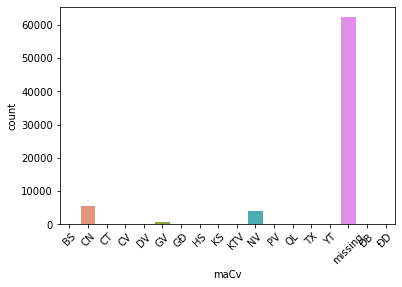

In [112]:
sns.countplot(x='maCv', data=object_columns_df)
plt.xticks(rotation=45)
plt.show()

In [113]:
missing_category = object_columns_df.isnull().sum()
missing_category = ['Field_1', 'Field_6', 'Field_7', 'Field_8', 'Field_25', 'Field_33', 'Field_40', 'Field_43', 'Field_44',
                    'F_startDate', 'F_endDate', 'E_startDate', 'E_endDate', 'C_startDate', 'C_endDate', 'G_startDate',
                    'G_endDate', 'A_startDate', 'A_endDate']

In [114]:
object_columns_df = object_columns_df.drop(missing_category, axis=1)

In [115]:
null_category = missing_values(object_columns_df)
null_category

Có tất cả 30 cột.
Trog đó có 0 cột bị thiếu data


,Missing,Percent %


In [116]:
object_columns_df.shape

(73411, 30)

#### 5.2 Deeling with numeric feature

In [117]:
numerical_columns_df.head()

,id,label,Field_3,Field_19,Field_20,Field_23,Field_27,Field_28,Field_29,Field_39,...,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,1.0,1.0,NaN,4258600.0,16.0,NaN,NaN,NaN,1.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1,1
2,2,0.0,2.0,NaN,5000000.0,10.0,NaN,NaN,NaN,1.0,...,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1
4,4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,33.0,10.769445,6.466667,0.0,3,1


In [118]:
numerical_columns_df.shape

(73411, 46)

In [119]:
miss_numeric = missing_values(numerical_columns_df)
miss_numeric

Có tất cả 46 cột.
Trog đó có 43 cột bị thiếu data


,Missing,Percent %
Field_28,70632,96.2
Field_27,70524,96.1
Field_19,69307,94.4
homeTownLatitude,56029,76.3
currentLocationLatitude,54414,74.1
Field_29,50981,69.4
Field_74,44993,61.3
topFriends,44841,61.1
Field_47,41229,56.2
Field_76,41055,55.9


In [120]:
missing_numeric = ['Field_28', 'Field_27', 'Field_19', 'homeTownLatitude', 'currentLocationLatitude',
                   'Field_29', 'Field_74']

In [121]:
numerical_columns_df = numerical_columns_df.drop(missing_numeric, axis=1)

Fill missng giá trị 0 cho những feature có dưới 30% độ thiếu hụt

In [122]:
numeric_columns_30 = ['label', 'A_numOrg', 'numOrg', 'partner0_A', 'partner0_G', 'partner1_A', 'partner3_A',
                      'partner3_D', 'partner5_A']

In [123]:
numerical_columns_df[numeric_columns_30] = numerical_columns_df[numeric_columns_30].fillna(0)

In [124]:
miss_numeric = missing_values(numerical_columns_df)
miss_numeric

Có tất cả 39 cột.
Trog đó có 27 cột bị thiếu data


,Missing,Percent %
topFriends,44841,61.1
Field_47,41229,56.2
Field_77,41055,55.9
Field_76,41055,55.9
Field_75,41055,55.9
Field_64,40681,55.4
Field_69,39810,54.2
F_numQuery,39602,53.9
F_numOrg,39602,53.9
G_numOrg,39314,53.6


Những columns còn lại fill bằng giá trị median()

In [125]:
def fill_median(df):
    for col in df.columns:
        median = df[col].median()
        df[col] = df[col].fillna(median)
    return df

In [126]:
numerical_columns_df = fill_median(numerical_columns_df)

In [127]:
numerical_columns_df.head()

,id,label,Field_3,Field_20,Field_23,Field_39,Field_47,Field_58,Field_59,Field_60,...,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,1.0,1.0,4258600.0,16.0,1.0,4.0,0.0,5.0,3.0,...,0.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
1,1,0.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,...,1.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
2,2,0.0,2.0,5000000.0,10.0,1.0,0.0,0.0,5.0,3.0,...,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,3,0.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,...,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1
4,4,1.0,2.0,3828230.0,14.0,1.0,1.0,0.0,5.0,3.0,...,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1


### 6.Encode category

In [128]:
object_columns_df.head()

,Field_4,Field_12,Field_18,Field_32,diaChi,Field_36,Field_45,Field_46,Field_48,Field_54,...,homeTownLocationId,currentLocationCity,currentLocationCountry,currentLocationName,currentLocationState,homeTownCity,homeTownName,homeTownState,brief,Giới Tính
0,gh,g8,trung tâm kinh doanh tiền mặt,2018-12-28,"23a bt1, bắc linh đàm, đại kim, hoàng mai, hà ...",dn,tf4354f,công ty tài chính tnhh mb shinsei,"tầng 9, tòa nhà mb, số 21 cát linh, đống đa, hn",vn,...,nan,nan,nan,nan,nan,nan,nan,nan,cb1,male
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,4,nan
2,t1,nan,nan,2019-01-17,"thôn khánh thọ, xã tam thái, huyện phú ninh, t...",dn,tb0648b,chi nhánh quảng nam- công ty cổ phần g-perform...,"tổ 2, khối châu trung, cẩm nam, hội an, quảng nam",nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1,female
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1,nan


In [129]:
object_columns_df.dtypes

Field_4                      category
Field_12                     category
Field_18                     category
Field_32                     category
diaChi                       category
Field_36                     category
Field_45                     category
Field_46                     category
Field_48                     category
Field_54                     category
Field_55                     category
Field_56                     category
Field_61                     category
Field_65                     category
Field_66                     category
Field_68                     category
maCv                         category
friendCount                  category
subscriberCount              category
currentLocationLocationId    category
homeTownLocationId           category
currentLocationCity          category
currentLocationCountry       category
currentLocationName          category
currentLocationState         category
homeTownCity                 category
homeTownName

In [130]:
app = object_columns_df.select_dtypes('category').apply(pd.Series.nunique, axis = 0)
app

Field_4                          3
Field_12                         8
Field_18                      8625
Field_32                      2557
diaChi                       27459
Field_36                        35
Field_45                     13360
Field_46                     17778
Field_48                     15570
Field_54                        50
Field_55                       236
Field_56                      1516
Field_61                        37
Field_65                        11
Field_66                         9
Field_68                     14691
maCv                            18
friendCount                      1
subscriberCount                  1
currentLocationLocationId     1439
homeTownLocationId            1580
currentLocationCity           1021
currentLocationCountry          52
currentLocationName           1276
currentLocationState           236
homeTownCity                  1013
homeTownName                  1306
homeTownState                  170
brief               

In [131]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in object_columns_df:
    if object_columns_df[col].dtype == 'category':
        # If 2 or fewer unique categories
        if len(list(object_columns_df[col].unique())) <= 27459:
            # Train on the training data
            le.fit(object_columns_df[col])
            # Transform both training and testing data
            object_columns_df[col] = le.transform(object_columns_df[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

30 columns were label encoded.


### 7.Model

In [132]:
df_final = pd.concat([object_columns_df, numerical_columns_df], axis=1,sort=False)
df_final.head()

,Field_4,Field_12,Field_18,Field_32,diaChi,Field_36,Field_45,Field_46,Field_48,Field_54,...,partner1_A,partner3_A,partner3_D,partner5_A,Field_78,Field_79,Field_80,Field_81,Field_82,train
0,0,4,7850,1641,4009,8,8219,10752,12700,48,...,0.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
1,1,7,6559,2556,14038,21,4477,13451,7897,30,...,1.0,0.0,0.0,0.0,16.0,17.039171,1.550000,0.0,1,1
2,2,7,6559,1661,18343,8,6738,1183,12827,30,...,0.0,1.0,0.0,1.0,33.0,10.769445,6.466667,0.0,2,1
3,1,7,6559,2556,14038,21,4477,13451,7897,30,...,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1
4,1,7,6559,2556,14038,21,4477,13451,7897,30,...,0.0,0.0,0.0,0.0,33.0,10.769445,6.466667,0.0,3,1


In [133]:
#df_final = df_final.drop(['id',],axis=1)

In [134]:
df_train = df_final[df_final['train'] == 1]
df_train = df_train.drop(['train',],axis=1)


df_test = df_final[df_final['train'] == 0]
#df_test = df_test.drop(['label'],axis=1)
df_test = df_test.drop(['train',],axis=1)

In [135]:
print(df_train.shape)
print(df_test.shape)

(53030, 68)
(20381, 68)


In [136]:
df_train['id']

0            0
1            1
2            2
3            3
4            4
         ...  
53025    53025
53026    53026
53027    53027
53028    53028
53029    53029
Name: id, Length: 53030, dtype: int64

In [140]:
import lightgbm as lgb
from unidecode import unidecode
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [138]:
y_label = df_train["label"]

In [141]:
def gini(y_true, y_score):
    return roc_auc_score(y_true, y_score)*2 - 1

def lgb_gini(y_pred, dataset_true):
    y_true = dataset_true.get_label()
    return 'gini', gini(y_true, y_pred), True

NUM_BOOST_ROUND = 1000

lgbm_param = {'objective':'binary',
              'boosting_type': 'gbdt',
              'metric' : 'auc',
              'learning_rate': 0.015,
              "bagging_freq": 1,
              "bagging_fraction" : 0.25,
              'tree_learner': 'serial',
              'reg_lambda': 2,
              'reg_alpha': 1,              
              "feature_fraction": 0.15,
              'num_leaves': 16,
              'max_depth': 8,
              'random_state': 16111997,
            }

seeds = np.random.randint(0, 10000, 3)
preds = 0    
feature_important = None
avg_train_gini = 0
avg_val_gini = 0

for s in seeds:
    skf = StratifiedKFold(n_splits=5, random_state=s, shuffle=True)        
    lgbm_param['random_state'] = s    
    seed_train_gini = 0
    seed_val_gini = 0
    for i, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(y_label)), y_label)):                
        X_train, X_val = df_train.iloc[train_idx].drop(["id"], 1), df_train.iloc[val_idx].drop(["id"], 1)                
        y_train, y_val = y_label[train_idx], y_label[val_idx]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval  = lgb.Dataset(X_val, y_val)

        evals_result = {} 
        model = lgb.train(lgbm_param,
                    lgb_train,
                    num_boost_round=NUM_BOOST_ROUND,  
                    early_stopping_rounds=50,
                    feval=lgb_gini,
                    verbose_eval=False,
                    evals_result=evals_result,
                    valid_sets=[lgb_train, lgb_eval])

        seed_train_gini += model.best_score["training"]["gini"] / skf.n_splits
        seed_val_gini += model.best_score["valid_1"]["gini"] / skf.n_splits

        avg_train_gini += model.best_score["training"]["gini"] / (len(seeds) * skf.n_splits)
        avg_val_gini += model.best_score["valid_1"]["gini"] / (len(seeds) * skf.n_splits)

        if feature_important is None:
            feature_important = model.feature_importance() / (len(seeds) * skf.n_splits)
        else:
            feature_important += model.feature_importance() / (len(seeds) * skf.n_splits)        

        pred = model.predict(test_fe.drop(["id"], 1))
        preds += pred / (skf.n_splits * len(seeds))
        
        print("Fold {}: {}/{}".format(i, model.best_score["training"]["gini"], model.best_score["valid_1"]["gini"]))
    print("Seed {}: {}/{}".format(s, seed_train_gini, seed_val_gini))

print("-" * 30)
print("Avg train gini: {}".format(avg_train_gini))
print("Avg valid gini: {}".format(avg_val_gini))
print("=" * 30)

LightGBMError: Do not support non-ASCII characters in feature name.